# Importamos librerías

In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from keras.regularizers import l1, l2

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

# Importamos los datos

In [4]:
path = '../../../Base de datos con ruido/Trayectorias 100 eval'

## Datos de entrenamiento

### Datos

In [5]:
varftrain = np.load(path + '/varftrain.npy')
varftrain = np.transpose(varftrain, (0,3,1,2))

In [6]:
np.shape(varftrain)

(7000, 100, 10, 2)

### Coeficientes

In [7]:
coefvarftrain = np.load(path + '/coefvarftrain.npy')

In [8]:
np.shape(coefvarftrain)

(7000, 7)

## Datos de prueba

### Datos

In [9]:
varftest = np.load(path + '/varftest.npy')
varftest = np.transpose(varftest, (0,3,1,2))

In [10]:
np.shape(varftest)

(2000, 100, 10, 2)

### Coeficientes

In [11]:
coefvarftest = np.load(path + '/coefvarftest.npy')

In [12]:
np.shape(coefvarftest)

(2000, 7)

## Datos de validación

### Datos

In [13]:
varfval = np.load(path + '/varfval.npy')
varfval = np.transpose(varfval, (0,3,1,2))

In [14]:
np.shape(varfval)

(1000, 100, 10, 2)

### Coeficienes

In [15]:
coefvarfval = np.load(path + '/coefvarfval.npy')

In [16]:
np.shape(coefvarfval)

(1000, 7)

# Unimos coeficientes con los datos

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((varftrain, coefvarftrain))
test_dataset = tf.data.Dataset.from_tensor_slices((varftest, coefvarftest))
val_dataset = tf.data.Dataset.from_tensor_slices((varfval, coefvarfval))

In [18]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(100, 10, 2), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>

# Mezclar y procesar por lotes los conjuntos de datos

In [19]:
BATCH_SIZE = 100
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Creación del modelo

In [20]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [21]:
model = Sequential()
# Primera capa convolucional
model.add(Conv2D(50, (5, 1), activation='tanh', input_shape=(100, 10, 2),kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 1)))

# Segunda capa convolucional
model.add(Conv2D(24, (5, 1), activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001) ))
model.add(MaxPooling2D(pool_size=(2, 1)))

# Tercera capa convolucional
model.add(Conv2D(11, (5, 1), activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(MaxPooling2D(pool_size=(2, 1)))

#Cuarta capa convolucional
model.add(Conv2D(50, (5, 2), activation='tanh'))
model.add(MaxPooling2D(pool_size=(2, 1)))

#Aplanamos la entrada
model.add(Flatten())

#Capas densas
model.add(Dense(100, activation='tanh', kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(50, activation='tanh', kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dense(20,activation = 'relu', kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)))
model.add(Dropout(0.3))
model.add(Dense(7, activation= custom_activation))


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 10, 50)        550       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 10, 50)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 10, 24)        6024      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 10, 24)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 10, 11)        1331      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 9, 10, 11)        0

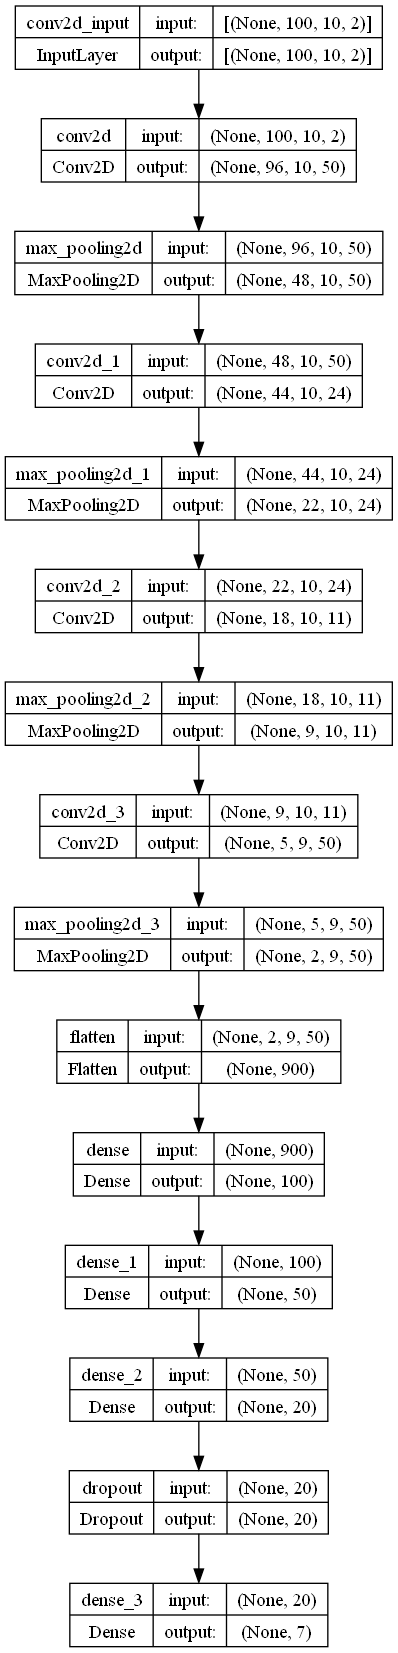

In [23]:
keras.utils.plot_model(model,show_shapes=True)

# Entrenamos el modelo

In [25]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,clipvalue=100.0)

In [24]:
def total_mae_loss(y_true, y_pred):
    total_loss = 0
    num_parameters = 7
    for i in range(num_parameters):
        total_loss += tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])
    tf.print(y_true, summarize = -1)
    tf.print(y_pred, summarize = -1)
    return total_loss / num_parameters

In [26]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [27]:
model.compile(optimizer=optimizer,
              loss= 'mean_squared_error',
              metrics=metrics)

In [28]:
def scheduler(epoch, lr):
  if epoch < 400:
    return lr
  else:
    return -1.65e-6*epoch +  0.00166

In [29]:
val_epochs = 1000

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 1000,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_dataset, validation_data=val_dataset, epochs= val_epochs, callbacks=[reduce_lr, early_stop])

Epoch 1/1000
70/70 [==============================] - 2s 15ms/step - loss: 13.0306 - a_1: 2.7553 - a_2: 2.7423 - b_1: 2.6094 - b_2: 2.4386 - d_1: 2.3694 - d_2: 2.2024 - n: 1.7863 - mean_metric: 0.5603 - val_loss: 11.4993 - val_a_1: 2.7278 - val_a_2: 2.6627 - val_b_1: 2.3420 - val_b_2: 2.2711 - val_d_1: 2.0119 - val_d_2: 1.8766 - val_n: 1.5799 - val_mean_metric: 0.5077 - lr: 0.0010
Epoch 2/1000
70/70 [==============================] - 1s 11ms/step - loss: 11.5901 - a_1: 2.7385 - a_2: 2.7104 - b_1: 2.4511 - b_2: 2.3436 - d_1: 2.0265 - d_2: 1.9103 - n: 1.6439 - mean_metric: 0.5245 - val_loss: 10.3978 - val_a_1: 2.7180 - val_a_2: 2.6403 - val_b_1: 2.3090 - val_b_2: 2.1735 - val_d_1: 1.8034 - val_d_2: 1.7131 - val_n: 1.5103 - val_mean_metric: 0.4879 - lr: 0.0010
Epoch 3/1000
70/70 [==============================] - 1s 11ms/step - loss: 10.5917 - a_1: 2.7397 - a_2: 2.7125 - b_1: 2.3243 - b_2: 2.2720 - d_1: 1.8545 - d_2: 1.7586 - n: 1.6259 - mean_metric: 0.5067 - val_loss: 9.4927 - val_a_1: 2

70/70 [==============================] - 1s 11ms/step - loss: 5.4155 - a_1: 2.5812 - a_2: 2.5518 - b_1: 1.5523 - b_2: 1.5069 - d_1: 0.8886 - d_2: 0.9493 - n: 1.4443 - mean_metric: 0.3804 - val_loss: 4.8710 - val_a_1: 2.5713 - val_a_2: 2.5402 - val_b_1: 1.3518 - val_b_2: 1.3577 - val_d_1: 0.5533 - val_d_2: 0.5838 - val_n: 1.4222 - val_mean_metric: 0.3406 - lr: 0.0010
Epoch 44/1000
70/70 [==============================] - 1s 11ms/step - loss: 5.3903 - a_1: 2.5794 - a_2: 2.5540 - b_1: 1.5474 - b_2: 1.4873 - d_1: 0.8947 - d_2: 0.9221 - n: 1.4466 - mean_metric: 0.3789 - val_loss: 4.7275 - val_a_1: 2.5723 - val_a_2: 2.5023 - val_b_1: 1.3373 - val_b_2: 1.2783 - val_d_1: 0.5208 - val_d_2: 0.5484 - val_n: 1.4114 - val_mean_metric: 0.3338 - lr: 0.0010
Epoch 45/1000
70/70 [==============================] - 1s 11ms/step - loss: 5.3696 - a_1: 2.5809 - a_2: 2.5458 - b_1: 1.5537 - b_2: 1.4902 - d_1: 0.8878 - d_2: 0.9436 - n: 1.4453 - mean_metric: 0.3794 - val_loss: 4.7567 - val_a_1: 2.5816 - val_a_2:

70/70 [==============================] - 1s 11ms/step - loss: 4.8638 - a_1: 2.5661 - a_2: 2.4539 - b_1: 1.4211 - b_2: 1.2965 - d_1: 0.8107 - d_2: 0.8682 - n: 1.4216 - mean_metric: 0.3593 - val_loss: 4.3431 - val_a_1: 2.5629 - val_a_2: 2.3775 - val_b_1: 1.1891 - val_b_2: 1.1833 - val_d_1: 0.4705 - val_d_2: 0.6181 - val_n: 1.3867 - val_mean_metric: 0.3212 - lr: 0.0010
Epoch 86/1000
70/70 [==============================] - 1s 11ms/step - loss: 4.8367 - a_1: 2.5627 - a_2: 2.4610 - b_1: 1.3858 - b_2: 1.2791 - d_1: 0.8241 - d_2: 0.8685 - n: 1.4230 - mean_metric: 0.3582 - val_loss: 4.3034 - val_a_1: 2.5707 - val_a_2: 2.3821 - val_b_1: 1.1897 - val_b_2: 1.2280 - val_d_1: 0.4800 - val_d_2: 0.5014 - val_n: 1.3888 - val_mean_metric: 0.3196 - lr: 0.0010
Epoch 87/1000
70/70 [==============================] - 1s 11ms/step - loss: 4.7988 - a_1: 2.5633 - a_2: 2.4395 - b_1: 1.3789 - b_2: 1.3028 - d_1: 0.8087 - d_2: 0.8357 - n: 1.4170 - mean_metric: 0.3562 - val_loss: 4.3103 - val_a_1: 2.5596 - val_a_2:

70/70 [==============================] - 1s 11ms/step - loss: 4.5415 - a_1: 2.5332 - a_2: 2.2945 - b_1: 1.3036 - b_2: 1.1988 - d_1: 0.7972 - d_2: 0.8455 - n: 1.4200 - mean_metric: 0.3445 - val_loss: 4.2500 - val_a_1: 2.5280 - val_a_2: 2.3962 - val_b_1: 1.2742 - val_b_2: 1.1080 - val_d_1: 0.4596 - val_d_2: 0.4793 - val_n: 1.3755 - val_mean_metric: 0.3157 - lr: 0.0010
Epoch 128/1000
70/70 [==============================] - 1s 11ms/step - loss: 4.5083 - a_1: 2.5252 - a_2: 2.3060 - b_1: 1.2623 - b_2: 1.1944 - d_1: 0.8079 - d_2: 0.8028 - n: 1.4164 - mean_metric: 0.3419 - val_loss: 4.2742 - val_a_1: 2.5191 - val_a_2: 2.3776 - val_b_1: 1.2510 - val_b_2: 1.0834 - val_d_1: 0.6022 - val_d_2: 0.5539 - val_n: 1.3712 - val_mean_metric: 0.3202 - lr: 0.0010
Epoch 129/1000
70/70 [==============================] - 1s 11ms/step - loss: 4.4903 - a_1: 2.5158 - a_2: 2.3113 - b_1: 1.2622 - b_2: 1.1829 - d_1: 0.7839 - d_2: 0.8146 - n: 1.4138 - mean_metric: 0.3409 - val_loss: 4.2388 - val_a_1: 2.5380 - val_a_

70/70 [==============================] - 1s 11ms/step - loss: 4.2498 - a_1: 2.4390 - a_2: 2.0881 - b_1: 1.2015 - b_2: 1.1473 - d_1: 0.8072 - d_2: 0.7943 - n: 1.4268 - mean_metric: 0.3283 - val_loss: 4.3117 - val_a_1: 2.4966 - val_a_2: 2.4211 - val_b_1: 1.2551 - val_b_2: 1.1413 - val_d_1: 0.4790 - val_d_2: 0.4868 - val_n: 1.4097 - val_mean_metric: 0.3180 - lr: 0.0010
Epoch 170/1000
70/70 [==============================] - 1s 11ms/step - loss: 4.2231 - a_1: 2.4143 - a_2: 2.1024 - b_1: 1.2070 - b_2: 1.1487 - d_1: 0.7774 - d_2: 0.7738 - n: 1.4273 - mean_metric: 0.3265 - val_loss: 4.2218 - val_a_1: 2.4547 - val_a_2: 2.4183 - val_b_1: 1.2091 - val_b_2: 1.0663 - val_d_1: 0.4837 - val_d_2: 0.5059 - val_n: 1.4052 - val_mean_metric: 0.3132 - lr: 0.0010
Epoch 171/1000
70/70 [==============================] - 1s 11ms/step - loss: 4.2624 - a_1: 2.4193 - a_2: 2.1004 - b_1: 1.1850 - b_2: 1.1820 - d_1: 0.7917 - d_2: 0.8151 - n: 1.4302 - mean_metric: 0.3290 - val_loss: 4.3016 - val_a_1: 2.4707 - val_a_

70/70 [==============================] - 1s 11ms/step - loss: 4.0279 - a_1: 2.3061 - a_2: 1.9469 - b_1: 1.1773 - b_2: 1.1193 - d_1: 0.7877 - d_2: 0.7799 - n: 1.4384 - mean_metric: 0.3168 - val_loss: 4.4217 - val_a_1: 2.4429 - val_a_2: 2.5020 - val_b_1: 1.2805 - val_b_2: 1.1096 - val_d_1: 0.4706 - val_d_2: 0.5508 - val_n: 1.4277 - val_mean_metric: 0.3211 - lr: 0.0010
Epoch 212/1000
70/70 [==============================] - 1s 11ms/step - loss: 4.0329 - a_1: 2.3024 - a_2: 1.9397 - b_1: 1.1867 - b_2: 1.1269 - d_1: 0.7763 - d_2: 0.7982 - n: 1.4422 - mean_metric: 0.3173 - val_loss: 4.4389 - val_a_1: 2.4454 - val_a_2: 2.4766 - val_b_1: 1.3225 - val_b_2: 1.1207 - val_d_1: 0.4716 - val_d_2: 0.5175 - val_n: 1.4310 - val_mean_metric: 0.3211 - lr: 0.0010
Epoch 213/1000
70/70 [==============================] - 1s 11ms/step - loss: 4.0219 - a_1: 2.3201 - a_2: 1.9417 - b_1: 1.1780 - b_2: 1.1013 - d_1: 0.7683 - d_2: 0.7956 - n: 1.4390 - mean_metric: 0.3164 - val_loss: 4.4602 - val_a_1: 2.4633 - val_a_

70/70 [==============================] - 1s 11ms/step - loss: 3.8751 - a_1: 2.2190 - a_2: 1.7840 - b_1: 1.2080 - b_2: 1.1079 - d_1: 0.7541 - d_2: 0.7955 - n: 1.4462 - mean_metric: 0.3088 - val_loss: 4.6189 - val_a_1: 2.4997 - val_a_2: 2.6238 - val_b_1: 1.2205 - val_b_2: 1.1425 - val_d_1: 0.4895 - val_d_2: 0.4535 - val_n: 1.4320 - val_mean_metric: 0.3236 - lr: 0.0010
Epoch 254/1000
70/70 [==============================] - 1s 11ms/step - loss: 3.8747 - a_1: 2.2353 - a_2: 1.7638 - b_1: 1.1950 - b_2: 1.0876 - d_1: 0.7734 - d_2: 0.7886 - n: 1.4473 - mean_metric: 0.3080 - val_loss: 4.7173 - val_a_1: 2.4868 - val_a_2: 2.6714 - val_b_1: 1.2599 - val_b_2: 1.1402 - val_d_1: 0.4678 - val_d_2: 0.5097 - val_n: 1.4256 - val_mean_metric: 0.3269 - lr: 0.0010
Epoch 255/1000
70/70 [==============================] - 1s 11ms/step - loss: 3.9045 - a_1: 2.2156 - a_2: 1.8093 - b_1: 1.1932 - b_2: 1.1302 - d_1: 0.7632 - d_2: 0.7987 - n: 1.4427 - mean_metric: 0.3101 - val_loss: 4.6953 - val_a_1: 2.5005 - val_a_

70/70 [==============================] - 1s 11ms/step - loss: 3.7200 - a_1: 2.1720 - a_2: 1.6494 - b_1: 1.1755 - b_2: 1.0798 - d_1: 0.7774 - d_2: 0.7784 - n: 1.4532 - mean_metric: 0.3012 - val_loss: 4.9978 - val_a_1: 2.5163 - val_a_2: 2.8190 - val_b_1: 1.2957 - val_b_2: 1.1653 - val_d_1: 0.5050 - val_d_2: 0.5890 - val_n: 1.4409 - val_mean_metric: 0.3390 - lr: 0.0010
Epoch 296/1000
70/70 [==============================] - 1s 11ms/step - loss: 3.7406 - a_1: 2.1544 - a_2: 1.6517 - b_1: 1.1740 - b_2: 1.0823 - d_1: 0.7777 - d_2: 0.8006 - n: 1.4552 - mean_metric: 0.3016 - val_loss: 4.9784 - val_a_1: 2.5160 - val_a_2: 2.7749 - val_b_1: 1.2926 - val_b_2: 1.2085 - val_d_1: 0.4988 - val_d_2: 0.5450 - val_n: 1.4400 - val_mean_metric: 0.3372 - lr: 0.0010
Epoch 297/1000
70/70 [==============================] - 1s 11ms/step - loss: 3.7362 - a_1: 2.1771 - a_2: 1.6521 - b_1: 1.1698 - b_2: 1.0865 - d_1: 0.7540 - d_2: 0.8009 - n: 1.4531 - mean_metric: 0.3014 - val_loss: 5.0151 - val_a_1: 2.4789 - val_a_

70/70 [==============================] - 1s 11ms/step - loss: 3.6724 - a_1: 2.1026 - a_2: 1.5611 - b_1: 1.1859 - b_2: 1.1025 - d_1: 0.7620 - d_2: 0.7973 - n: 1.4567 - mean_metric: 0.2973 - val_loss: 5.2220 - val_a_1: 2.5517 - val_a_2: 2.9515 - val_b_1: 1.2956 - val_b_2: 1.2114 - val_d_1: 0.4636 - val_d_2: 0.4931 - val_n: 1.4407 - val_mean_metric: 0.3415 - lr: 0.0010
Epoch 338/1000
70/70 [==============================] - 1s 11ms/step - loss: 3.6441 - a_1: 2.1172 - a_2: 1.5560 - b_1: 1.1924 - b_2: 1.0513 - d_1: 0.7740 - d_2: 0.7768 - n: 1.4541 - mean_metric: 0.2958 - val_loss: 5.1789 - val_a_1: 2.5349 - val_a_2: 2.9451 - val_b_1: 1.2549 - val_b_2: 1.2336 - val_d_1: 0.5013 - val_d_2: 0.4759 - val_n: 1.4389 - val_mean_metric: 0.3407 - lr: 0.0010
Epoch 339/1000
70/70 [==============================] - 1s 11ms/step - loss: 3.6342 - a_1: 2.1007 - a_2: 1.5685 - b_1: 1.1876 - b_2: 1.0526 - d_1: 0.7632 - d_2: 0.7724 - n: 1.4585 - mean_metric: 0.2951 - val_loss: 5.1737 - val_a_1: 2.5452 - val_a_

70/70 [==============================] - 1s 11ms/step - loss: 3.5938 - a_1: 2.0630 - a_2: 1.5268 - b_1: 1.1970 - b_2: 1.0777 - d_1: 0.7513 - d_2: 0.7762 - n: 1.4595 - mean_metric: 0.2934 - val_loss: 5.4298 - val_a_1: 2.5573 - val_a_2: 3.1260 - val_b_1: 1.2747 - val_b_2: 1.2877 - val_d_1: 0.4681 - val_d_2: 0.4589 - val_n: 1.4442 - val_mean_metric: 0.3483 - lr: 0.0010
Epoch 380/1000
70/70 [==============================] - 1s 11ms/step - loss: 3.5795 - a_1: 2.0559 - a_2: 1.5453 - b_1: 1.1726 - b_2: 1.0611 - d_1: 0.7688 - d_2: 0.7789 - n: 1.4579 - mean_metric: 0.2930 - val_loss: 5.4389 - val_a_1: 2.5591 - val_a_2: 3.0830 - val_b_1: 1.3053 - val_b_2: 1.2320 - val_d_1: 0.5029 - val_d_2: 0.4928 - val_n: 1.4388 - val_mean_metric: 0.3483 - lr: 0.0010
Epoch 381/1000
70/70 [==============================] - 1s 11ms/step - loss: 3.6007 - a_1: 2.0598 - a_2: 1.5250 - b_1: 1.2215 - b_2: 1.0832 - d_1: 0.7730 - d_2: 0.7912 - n: 1.4543 - mean_metric: 0.2953 - val_loss: 5.3884 - val_a_1: 2.5664 - val_a_

70/70 [==============================] - 1s 11ms/step - loss: 3.5011 - a_1: 1.9326 - a_2: 1.5366 - b_1: 1.2192 - b_2: 1.0572 - d_1: 0.7625 - d_2: 0.7694 - n: 1.4559 - mean_metric: 0.2895 - val_loss: 5.3591 - val_a_1: 2.6078 - val_a_2: 2.9554 - val_b_1: 1.3175 - val_b_2: 1.1687 - val_d_1: 0.4875 - val_d_2: 0.4812 - val_n: 1.4405 - val_mean_metric: 0.3431 - lr: 9.6700e-04
Epoch 422/1000
70/70 [==============================] - 1s 11ms/step - loss: 3.4904 - a_1: 1.9138 - a_2: 1.5437 - b_1: 1.2212 - b_2: 1.0447 - d_1: 0.7509 - d_2: 0.7679 - n: 1.4573 - mean_metric: 0.2884 - val_loss: 5.3736 - val_a_1: 2.6292 - val_a_2: 2.9545 - val_b_1: 1.3136 - val_b_2: 1.2137 - val_d_1: 0.5027 - val_d_2: 0.4888 - val_n: 1.4361 - val_mean_metric: 0.3458 - lr: 9.6535e-04
Epoch 423/1000
70/70 [==============================] - 1s 11ms/step - loss: 3.5134 - a_1: 1.9147 - a_2: 1.5379 - b_1: 1.2147 - b_2: 1.0704 - d_1: 0.7653 - d_2: 0.7794 - n: 1.4554 - mean_metric: 0.2896 - val_loss: 5.4603 - val_a_1: 2.5988 

70/70 [==============================] - 1s 11ms/step - loss: 3.2941 - a_1: 1.8506 - a_2: 1.3769 - b_1: 1.1732 - b_2: 1.0251 - d_1: 0.7470 - d_2: 0.7580 - n: 1.4572 - mean_metric: 0.2781 - val_loss: 5.4471 - val_a_1: 2.6558 - val_a_2: 3.0173 - val_b_1: 1.2648 - val_b_2: 1.1752 - val_d_1: 0.4936 - val_d_2: 0.5187 - val_n: 1.4446 - val_mean_metric: 0.3468 - lr: 8.9770e-04
Epoch 464/1000
70/70 [==============================] - 1s 11ms/step - loss: 3.3434 - a_1: 1.8370 - a_2: 1.4121 - b_1: 1.1920 - b_2: 1.0327 - d_1: 0.7536 - d_2: 0.7775 - n: 1.4622 - mean_metric: 0.2807 - val_loss: 5.4229 - val_a_1: 2.6350 - val_a_2: 3.0194 - val_b_1: 1.2872 - val_b_2: 1.1773 - val_d_1: 0.4603 - val_d_2: 0.4829 - val_n: 1.4474 - val_mean_metric: 0.3448 - lr: 8.9605e-04
Epoch 465/1000
70/70 [==============================] - 1s 11ms/step - loss: 3.3897 - a_1: 1.8417 - a_2: 1.4245 - b_1: 1.2322 - b_2: 1.0540 - d_1: 0.7508 - d_2: 0.7735 - n: 1.4600 - mean_metric: 0.2830 - val_loss: 5.4544 - val_a_1: 2.6504 

70/70 [==============================] - 1s 11ms/step - loss: 3.3322 - a_1: 1.8306 - a_2: 1.4070 - b_1: 1.1894 - b_2: 1.0340 - d_1: 0.7512 - d_2: 0.7484 - n: 1.4598 - mean_metric: 0.2792 - val_loss: 5.4631 - val_a_1: 2.6555 - val_a_2: 3.0182 - val_b_1: 1.3234 - val_b_2: 1.2298 - val_d_1: 0.4619 - val_d_2: 0.4786 - val_n: 1.4496 - val_mean_metric: 0.3484 - lr: 8.2840e-04
Epoch 506/1000
70/70 [==============================] - 1s 11ms/step - loss: 3.3259 - a_1: 1.8384 - a_2: 1.3931 - b_1: 1.1980 - b_2: 1.0187 - d_1: 0.7432 - d_2: 0.7631 - n: 1.4633 - mean_metric: 0.2790 - val_loss: 5.5173 - val_a_1: 2.6793 - val_a_2: 3.0293 - val_b_1: 1.3364 - val_b_2: 1.1987 - val_d_1: 0.4633 - val_d_2: 0.4751 - val_n: 1.4501 - val_mean_metric: 0.3489 - lr: 8.2675e-04
Epoch 507/1000
70/70 [==============================] - 1s 11ms/step - loss: 3.3493 - a_1: 1.8366 - a_2: 1.3909 - b_1: 1.1954 - b_2: 1.0474 - d_1: 0.7612 - d_2: 0.7623 - n: 1.4625 - mean_metric: 0.2803 - val_loss: 5.5665 - val_a_1: 2.6640 

70/70 [==============================] - 1s 11ms/step - loss: 3.2321 - a_1: 1.7954 - a_2: 1.3245 - b_1: 1.1685 - b_2: 0.9953 - d_1: 0.7610 - d_2: 0.7486 - n: 1.4614 - mean_metric: 0.2736 - val_loss: 5.6514 - val_a_1: 2.6991 - val_a_2: 3.1129 - val_b_1: 1.3489 - val_b_2: 1.1917 - val_d_1: 0.4833 - val_d_2: 0.4682 - val_n: 1.4511 - val_mean_metric: 0.3529 - lr: 7.5910e-04
Epoch 548/1000
70/70 [==============================] - 1s 11ms/step - loss: 3.2233 - a_1: 1.7819 - a_2: 1.3124 - b_1: 1.1697 - b_2: 1.0107 - d_1: 0.7450 - d_2: 0.7696 - n: 1.4603 - mean_metric: 0.2735 - val_loss: 5.6574 - val_a_1: 2.6937 - val_a_2: 3.1554 - val_b_1: 1.2811 - val_b_2: 1.1936 - val_d_1: 0.4844 - val_d_2: 0.4610 - val_n: 1.4489 - val_mean_metric: 0.3517 - lr: 7.5745e-04
Epoch 549/1000
70/70 [==============================] - 1s 11ms/step - loss: 3.2096 - a_1: 1.7549 - a_2: 1.3151 - b_1: 1.1794 - b_2: 1.0232 - d_1: 0.7483 - d_2: 0.7662 - n: 1.4629 - mean_metric: 0.2735 - val_loss: 5.6669 - val_a_1: 2.7056 

70/70 [==============================] - 1s 11ms/step - loss: 3.2036 - a_1: 1.7673 - a_2: 1.3144 - b_1: 1.1786 - b_2: 1.0148 - d_1: 0.7454 - d_2: 0.7465 - n: 1.4607 - mean_metric: 0.2727 - val_loss: 5.6385 - val_a_1: 2.7380 - val_a_2: 3.1124 - val_b_1: 1.2690 - val_b_2: 1.1912 - val_d_1: 0.4745 - val_d_2: 0.4823 - val_n: 1.4515 - val_mean_metric: 0.3517 - lr: 6.8980e-04
Epoch 590/1000
70/70 [==============================] - 1s 11ms/step - loss: 3.1632 - a_1: 1.7474 - a_2: 1.2898 - b_1: 1.1836 - b_2: 0.9922 - d_1: 0.7320 - d_2: 0.7520 - n: 1.4606 - mean_metric: 0.2704 - val_loss: 5.6984 - val_a_1: 2.7368 - val_a_2: 3.1391 - val_b_1: 1.2773 - val_b_2: 1.1861 - val_d_1: 0.4602 - val_d_2: 0.4555 - val_n: 1.4518 - val_mean_metric: 0.3513 - lr: 6.8815e-04
Epoch 591/1000
70/70 [==============================] - 1s 11ms/step - loss: 3.1933 - a_1: 1.7772 - a_2: 1.3074 - b_1: 1.1510 - b_2: 1.0034 - d_1: 0.7539 - d_2: 0.7506 - n: 1.4600 - mean_metric: 0.2720 - val_loss: 5.6598 - val_a_1: 2.7297 

70/70 [==============================] - 1s 11ms/step - loss: 3.1353 - a_1: 1.7608 - a_2: 1.2897 - b_1: 1.1533 - b_2: 0.9639 - d_1: 0.7464 - d_2: 0.7447 - n: 1.4602 - mean_metric: 0.2692 - val_loss: 5.5419 - val_a_1: 2.7506 - val_a_2: 2.9908 - val_b_1: 1.2688 - val_b_2: 1.2461 - val_d_1: 0.4726 - val_d_2: 0.4439 - val_n: 1.4582 - val_mean_metric: 0.3488 - lr: 6.2050e-04
Epoch 632/1000
70/70 [==============================] - 1s 11ms/step - loss: 3.2093 - a_1: 1.7549 - a_2: 1.3225 - b_1: 1.1946 - b_2: 0.9982 - d_1: 0.7558 - d_2: 0.7387 - n: 1.4602 - mean_metric: 0.2726 - val_loss: 5.4985 - val_a_1: 2.7066 - val_a_2: 2.9666 - val_b_1: 1.3089 - val_b_2: 1.2342 - val_d_1: 0.4850 - val_d_2: 0.5021 - val_n: 1.4584 - val_mean_metric: 0.3498 - lr: 6.1885e-04
Epoch 633/1000
70/70 [==============================] - 1s 11ms/step - loss: 3.1550 - a_1: 1.7415 - a_2: 1.2951 - b_1: 1.1682 - b_2: 1.0020 - d_1: 0.7352 - d_2: 0.7361 - n: 1.4570 - mean_metric: 0.2696 - val_loss: 5.4794 - val_a_1: 2.7138 

70/70 [==============================] - 1s 11ms/step - loss: 3.1157 - a_1: 1.7337 - a_2: 1.2451 - b_1: 1.1693 - b_2: 0.9872 - d_1: 0.7342 - d_2: 0.7443 - n: 1.4630 - mean_metric: 0.2678 - val_loss: 5.6510 - val_a_1: 2.7325 - val_a_2: 3.0679 - val_b_1: 1.3227 - val_b_2: 1.2825 - val_d_1: 0.4486 - val_d_2: 0.4390 - val_n: 1.4556 - val_mean_metric: 0.3527 - lr: 5.5120e-04
Epoch 674/1000
70/70 [==============================] - 1s 10ms/step - loss: 3.0934 - a_1: 1.7170 - a_2: 1.2632 - b_1: 1.1551 - b_2: 0.9597 - d_1: 0.7408 - d_2: 0.7458 - n: 1.4620 - mean_metric: 0.2667 - val_loss: 5.6001 - val_a_1: 2.7683 - val_a_2: 3.0311 - val_b_1: 1.2400 - val_b_2: 1.2220 - val_d_1: 0.4731 - val_d_2: 0.4629 - val_n: 1.4546 - val_mean_metric: 0.3495 - lr: 5.4955e-04
Epoch 675/1000
70/70 [==============================] - 1s 11ms/step - loss: 3.1309 - a_1: 1.7395 - a_2: 1.2758 - b_1: 1.1855 - b_2: 0.9831 - d_1: 0.7239 - d_2: 0.7285 - n: 1.4619 - mean_metric: 0.2684 - val_loss: 5.6423 - val_a_1: 2.7683 

70/70 [==============================] - 1s 11ms/step - loss: 3.0713 - a_1: 1.7086 - a_2: 1.2307 - b_1: 1.1585 - b_2: 0.9738 - d_1: 0.7347 - d_2: 0.7246 - n: 1.4593 - mean_metric: 0.2649 - val_loss: 5.7340 - val_a_1: 2.7965 - val_a_2: 3.0923 - val_b_1: 1.3191 - val_b_2: 1.2313 - val_d_1: 0.4405 - val_d_2: 0.4470 - val_n: 1.4544 - val_mean_metric: 0.3537 - lr: 4.8190e-04
Epoch 716/1000
70/70 [==============================] - 1s 11ms/step - loss: 3.0591 - a_1: 1.7217 - a_2: 1.2225 - b_1: 1.1430 - b_2: 0.9454 - d_1: 0.7381 - d_2: 0.7475 - n: 1.4618 - mean_metric: 0.2645 - val_loss: 5.6984 - val_a_1: 2.7710 - val_a_2: 3.0804 - val_b_1: 1.3029 - val_b_2: 1.2490 - val_d_1: 0.4681 - val_d_2: 0.4528 - val_n: 1.4534 - val_mean_metric: 0.3536 - lr: 4.8025e-04
Epoch 717/1000
70/70 [==============================] - 1s 11ms/step - loss: 3.0379 - a_1: 1.6967 - a_2: 1.2422 - b_1: 1.1393 - b_2: 0.9521 - d_1: 0.7149 - d_2: 0.7258 - n: 1.4572 - mean_metric: 0.2628 - val_loss: 5.6930 - val_a_1: 2.7643 

70/70 [==============================] - 1s 11ms/step - loss: 3.0758 - a_1: 1.7099 - a_2: 1.2477 - b_1: 1.1406 - b_2: 0.9517 - d_1: 0.7385 - d_2: 0.7363 - n: 1.4614 - mean_metric: 0.2647 - val_loss: 5.6776 - val_a_1: 2.7958 - val_a_2: 3.0567 - val_b_1: 1.2777 - val_b_2: 1.2220 - val_d_1: 0.4586 - val_d_2: 0.4640 - val_n: 1.4508 - val_mean_metric: 0.3519 - lr: 4.1260e-04
Epoch 758/1000
70/70 [==============================] - 1s 11ms/step - loss: 3.0485 - a_1: 1.7156 - a_2: 1.2089 - b_1: 1.1376 - b_2: 0.9505 - d_1: 0.7348 - d_2: 0.7444 - n: 1.4617 - mean_metric: 0.2637 - val_loss: 5.5912 - val_a_1: 2.7529 - val_a_2: 3.0487 - val_b_1: 1.2363 - val_b_2: 1.2261 - val_d_1: 0.4439 - val_d_2: 0.4367 - val_n: 1.4529 - val_mean_metric: 0.3477 - lr: 4.1095e-04
Epoch 759/1000
70/70 [==============================] - 1s 11ms/step - loss: 3.0619 - a_1: 1.7200 - a_2: 1.2063 - b_1: 1.1429 - b_2: 0.9369 - d_1: 0.7522 - d_2: 0.7522 - n: 1.4613 - mean_metric: 0.2642 - val_loss: 5.6764 - val_a_1: 2.8045 

70/70 [==============================] - 1s 11ms/step - loss: 3.0184 - a_1: 1.7022 - a_2: 1.1695 - b_1: 1.1614 - b_2: 0.9478 - d_1: 0.7426 - d_2: 0.7184 - n: 1.4605 - mean_metric: 0.2620 - val_loss: 5.7423 - val_a_1: 2.7958 - val_a_2: 3.1177 - val_b_1: 1.2604 - val_b_2: 1.2458 - val_d_1: 0.4571 - val_d_2: 0.4272 - val_n: 1.4551 - val_mean_metric: 0.3530 - lr: 3.4330e-04
Epoch 800/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.9997 - a_1: 1.6932 - a_2: 1.1889 - b_1: 1.1366 - b_2: 0.9321 - d_1: 0.7090 - d_2: 0.7304 - n: 1.4618 - mean_metric: 0.2602 - val_loss: 5.7782 - val_a_1: 2.8073 - val_a_2: 3.1366 - val_b_1: 1.2724 - val_b_2: 1.2369 - val_d_1: 0.4527 - val_d_2: 0.4355 - val_n: 1.4542 - val_mean_metric: 0.3542 - lr: 3.4165e-04
Epoch 801/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.9990 - a_1: 1.6928 - a_2: 1.1658 - b_1: 1.1503 - b_2: 0.9504 - d_1: 0.7198 - d_2: 0.7380 - n: 1.4612 - mean_metric: 0.2612 - val_loss: 5.7588 - val_a_1: 2.7969 

70/70 [==============================] - 1s 11ms/step - loss: 2.9582 - a_1: 1.6510 - a_2: 1.1766 - b_1: 1.1320 - b_2: 0.9309 - d_1: 0.7126 - d_2: 0.7156 - n: 1.4661 - mean_metric: 0.2580 - val_loss: 5.7345 - val_a_1: 2.7907 - val_a_2: 3.0992 - val_b_1: 1.2728 - val_b_2: 1.2309 - val_d_1: 0.4323 - val_d_2: 0.4343 - val_n: 1.4532 - val_mean_metric: 0.3515 - lr: 2.7400e-04
Epoch 842/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.9460 - a_1: 1.6587 - a_2: 1.1586 - b_1: 1.1198 - b_2: 0.9288 - d_1: 0.7144 - d_2: 0.7343 - n: 1.4632 - mean_metric: 0.2578 - val_loss: 5.7959 - val_a_1: 2.8340 - val_a_2: 3.0965 - val_b_1: 1.2675 - val_b_2: 1.2324 - val_d_1: 0.4301 - val_d_2: 0.4353 - val_n: 1.4542 - val_mean_metric: 0.3527 - lr: 2.7235e-04
Epoch 843/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.9510 - a_1: 1.6622 - a_2: 1.1734 - b_1: 1.1091 - b_2: 0.9423 - d_1: 0.7153 - d_2: 0.7238 - n: 1.4602 - mean_metric: 0.2581 - val_loss: 5.7504 - val_a_1: 2.8120 

70/70 [==============================] - 1s 11ms/step - loss: 2.9503 - a_1: 1.6432 - a_2: 1.1928 - b_1: 1.1084 - b_2: 0.9175 - d_1: 0.7200 - d_2: 0.7103 - n: 1.4642 - mean_metric: 0.2571 - val_loss: 5.8753 - val_a_1: 2.8359 - val_a_2: 3.1800 - val_b_1: 1.2321 - val_b_2: 1.2332 - val_d_1: 0.4401 - val_d_2: 0.4226 - val_n: 1.4520 - val_mean_metric: 0.3542 - lr: 2.0470e-04
Epoch 884/1000
70/70 [==============================] - 1s 10ms/step - loss: 2.9576 - a_1: 1.6604 - a_2: 1.1687 - b_1: 1.1323 - b_2: 0.9328 - d_1: 0.7180 - d_2: 0.7166 - n: 1.4620 - mean_metric: 0.2583 - val_loss: 5.8245 - val_a_1: 2.8269 - val_a_2: 3.1427 - val_b_1: 1.2450 - val_b_2: 1.2739 - val_d_1: 0.4400 - val_d_2: 0.4473 - val_n: 1.4514 - val_mean_metric: 0.3552 - lr: 2.0305e-04
Epoch 885/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.8950 - a_1: 1.6467 - a_2: 1.1479 - b_1: 1.1019 - b_2: 0.8901 - d_1: 0.7103 - d_2: 0.7359 - n: 1.4610 - mean_metric: 0.2550 - val_loss: 5.8740 - val_a_1: 2.8426 

70/70 [==============================] - 1s 11ms/step - loss: 2.9169 - a_1: 1.6319 - a_2: 1.1556 - b_1: 1.0974 - b_2: 0.9191 - d_1: 0.7232 - d_2: 0.7307 - n: 1.4631 - mean_metric: 0.2560 - val_loss: 5.8057 - val_a_1: 2.8334 - val_a_2: 3.1453 - val_b_1: 1.2469 - val_b_2: 1.2080 - val_d_1: 0.4319 - val_d_2: 0.4253 - val_n: 1.4515 - val_mean_metric: 0.3525 - lr: 1.3540e-04
Epoch 926/1000
70/70 [==============================] - 1s 10ms/step - loss: 2.8771 - a_1: 1.6449 - a_2: 1.1473 - b_1: 1.0942 - b_2: 0.9050 - d_1: 0.6937 - d_2: 0.7097 - n: 1.4614 - mean_metric: 0.2538 - val_loss: 5.8142 - val_a_1: 2.8374 - val_a_2: 3.1463 - val_b_1: 1.2508 - val_b_2: 1.2178 - val_d_1: 0.4301 - val_d_2: 0.4261 - val_n: 1.4518 - val_mean_metric: 0.3530 - lr: 1.3375e-04
Epoch 927/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.9309 - a_1: 1.6403 - a_2: 1.1629 - b_1: 1.1228 - b_2: 0.9042 - d_1: 0.7226 - d_2: 0.7108 - n: 1.4614 - mean_metric: 0.2561 - val_loss: 5.8078 - val_a_1: 2.8291 

70/70 [==============================] - 1s 11ms/step - loss: 2.8844 - a_1: 1.6265 - a_2: 1.1458 - b_1: 1.0947 - b_2: 0.9018 - d_1: 0.7095 - d_2: 0.7087 - n: 1.4658 - mean_metric: 0.2537 - val_loss: 5.6997 - val_a_1: 2.7821 - val_a_2: 3.1171 - val_b_1: 1.2383 - val_b_2: 1.2304 - val_d_1: 0.4220 - val_d_2: 0.4468 - val_n: 1.4541 - val_mean_metric: 0.3508 - lr: 6.6100e-05
Epoch 968/1000
70/70 [==============================] - 1s 11ms/step - loss: 2.8820 - a_1: 1.6146 - a_2: 1.1438 - b_1: 1.0935 - b_2: 0.9034 - d_1: 0.7188 - d_2: 0.7129 - n: 1.4620 - mean_metric: 0.2535 - val_loss: 5.6936 - val_a_1: 2.7874 - val_a_2: 3.1182 - val_b_1: 1.2310 - val_b_2: 1.2253 - val_d_1: 0.4225 - val_d_2: 0.4444 - val_n: 1.4532 - val_mean_metric: 0.3505 - lr: 6.4450e-05
Epoch 969/1000
70/70 [==============================] - 1s 10ms/step - loss: 2.8408 - a_1: 1.5909 - a_2: 1.1253 - b_1: 1.0904 - b_2: 0.9052 - d_1: 0.7067 - d_2: 0.6978 - n: 1.4599 - mean_metric: 0.2512 - val_loss: 5.6888 - val_a_1: 2.7839 

# Analizamos accuracy y loss

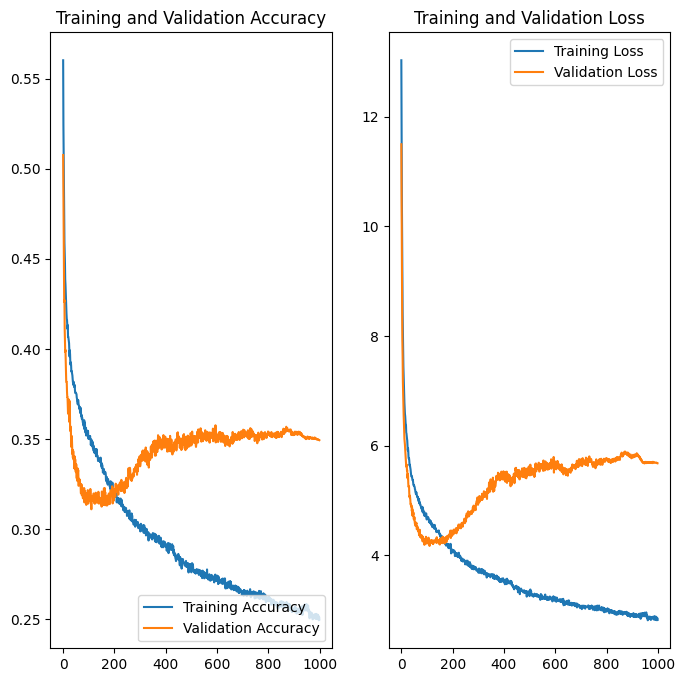

In [30]:
acc = history.history['mean_metric']
val_acc = history.history['val_mean_metric']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(val_epochs)
epochs_range = range(val_epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

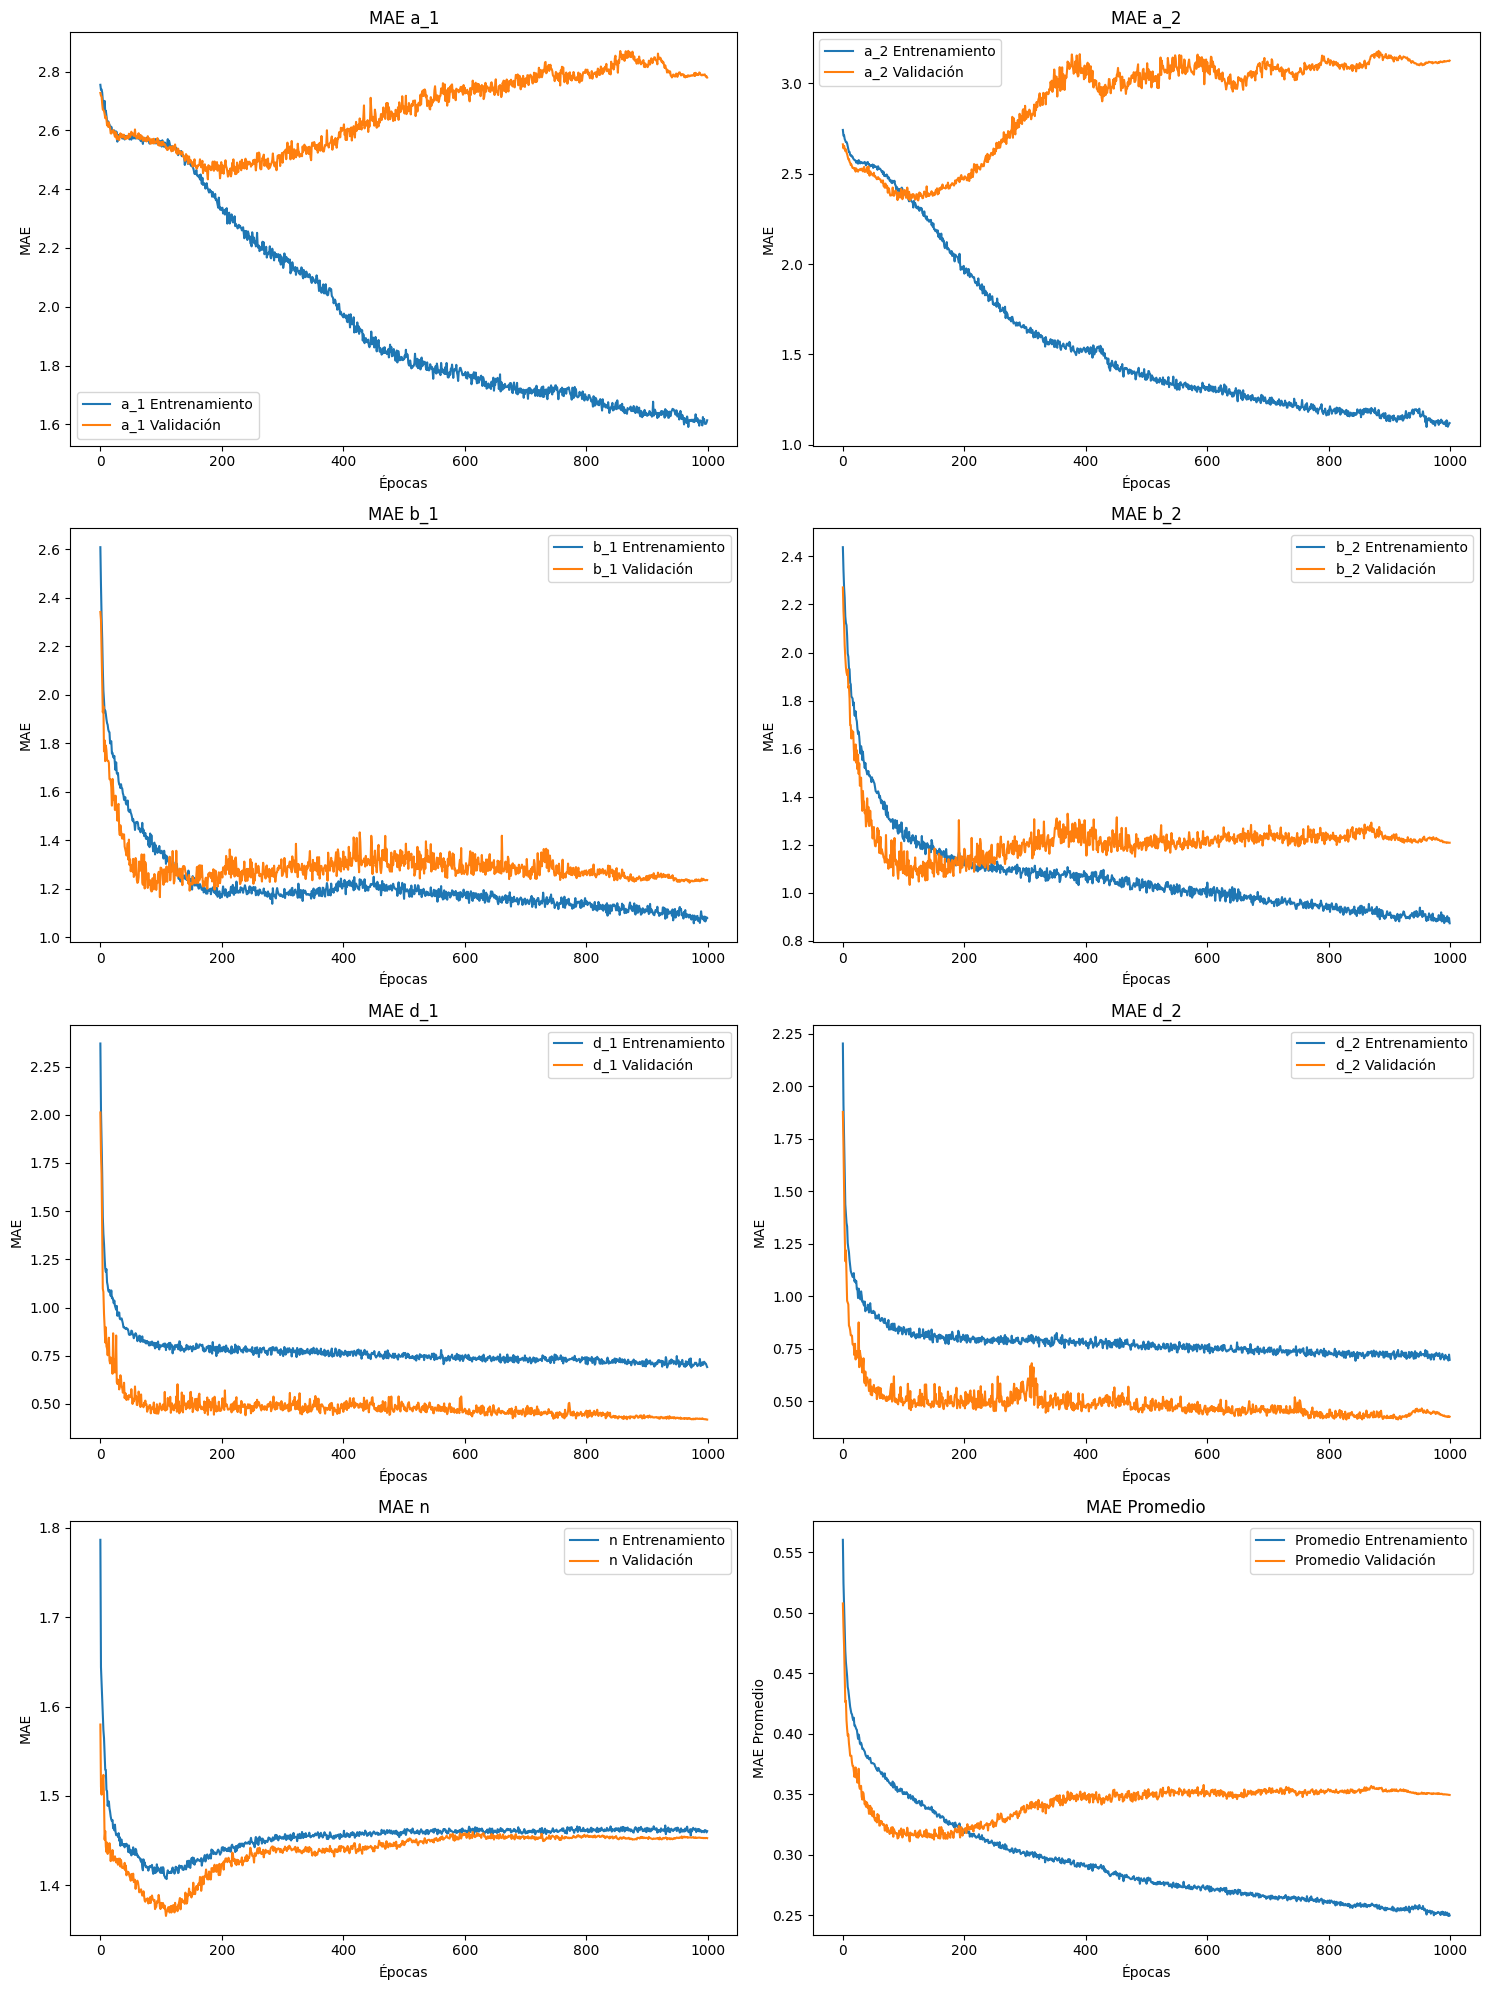

In [31]:
# Número de coeficientes más uno para la métrica adicional
n_coef = len(coeficientesnombres) + 1

# Número de filas y columnas para los subplots
n_rows = (n_coef + 1) // 2
n_cols = 2

# Crear una figura más grande para acomodar todos los subplots
plt.figure(figsize=(15, 5 * n_rows))

# Crear un subplot para cada coeficiente
for i, name in enumerate(coeficientesnombres):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.plot(history.history[name ], label=name + ' Entrenamiento')
    plt.plot(history.history['val_' + name ], label=name + ' Validación')
    plt.title('MAE ' + name)
    plt.xlabel('Épocas')
    plt.ylabel('MAE')
    plt.legend()

# Agregar un subplot para la métrica prom_per
plt.subplot(n_rows, n_cols, n_coef)
plt.plot(history.history['mean_metric'], label='Promedio Entrenamiento')
plt.plot(history.history['val_mean_metric'], label='Promedio Validación')
plt.title('MAE Promedio')
plt.xlabel('Épocas')
plt.ylabel('MAE Promedio')
plt.legend()

# Ajustar el diseño para asegurarse de que todo encaje bien
plt.tight_layout()
plt.show()

# Evaluamos el modelo

In [32]:
test_loss, test_a1, test_a2, test_b1, test_b2, test_d1, test_d2, test_n, testprom_per = model.evaluate(
    varftest, coefvarftest)

63/63 [==============================] - 0s 4ms/step - loss: 5.8857 - a_1: 2.7357 - a_2: 3.2740 - b_1: 1.2645 - b_2: 1.2059 - d_1: 0.4180 - d_2: 0.4246 - n: 1.4670 - mean_metric: 0.3565


In [33]:
predictions = model.predict(varftest)

63/63 [==============================] - 0s 1ms/step


In [34]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Calcula el MAE
mae = mean_absolute_error(coefvarftest, predictions)

# Calcula la desviación estándar del error
error = coefvarftest - predictions
std_dev = np.std(error)

# Calcula el error absoluto máximo
max_error = np.max(np.abs(error))

print(f"MAE: {mae}, Desviación estándar del error: {std_dev}, Error absoluto máximo: {max_error}")

MAE: 1.5413600676366728, Desviación estándar del error: 2.3177576760862073, Error absoluto máximo: 9.96235478296876


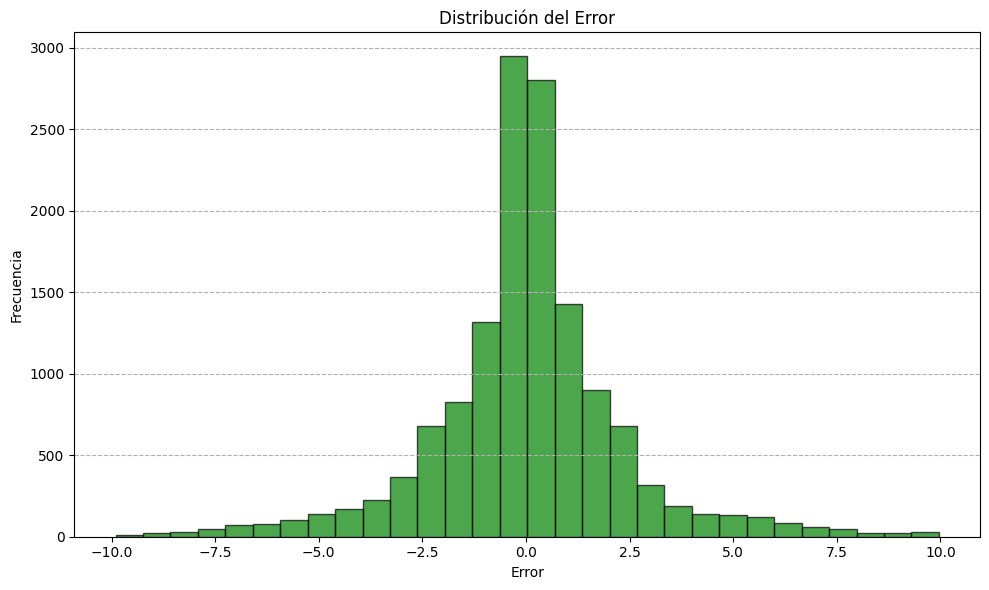

In [35]:
# Calcula el error absoluto para cada dato
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Establece el tamaño del gráfico
plt.hist(error.flatten(), bins=30, edgecolor='black', alpha=0.7, color = 'green')  # Añade bordes negros a las barras y ajusta la transparencia
plt.title('Distribución del Error')  # Añade un título al gráfico
plt.xlabel('Error')  # Etiqueta el eje x
plt.ylabel('Frecuencia')  # Etiqueta el eje y
plt.grid(axis='y', linestyle='--')  # Añade una cuadrícula horizontal
plt.tight_layout()  # Ajusta el diseño para evitar que se recorten las etiquetas
plt.show()

In [36]:
# Calcula el error absoluto para cada dato
absolute_error = np.abs(coefvarftest - predictions)

# Calcula el error para cada dato
error = coefvarftest - predictions

# Calcula la suma de los valores reales para cada dato
sum_real_values = np.sum(coefvarftest, axis=-1)

# Divide el error absoluto por la suma de los valores reales para cada dato
relative_error_per_data = np.sum(absolute_error, axis=-1) / sum_real_values

# Calcula el MAE relativo como la media de los errores relativos
relative_mae = np.mean(relative_error_per_data)

# Divide el error por la suma de los valores reales para cada dato
relative_error_per_data_std_max = np.sum(error, axis=-1) / sum_real_values

# Calcula la desviación estándar del error relativo
relative_std_dev = np.std(relative_error_per_data_std_max)

# Calcula el error absoluto máximo relativo
relative_max_error = np.max(np.abs(relative_error_per_data_std_max))

print(f"MAE relativo: {relative_mae}")
print(f"Desviación estándar del error relativo: {relative_std_dev}")
print(f"Error absoluto máximo relativo: {relative_max_error}")

MAE relativo: 0.35758775273910476
Desviación estándar del error relativo: 0.20364832905409136
Error absoluto máximo relativo: 1.754460057616234


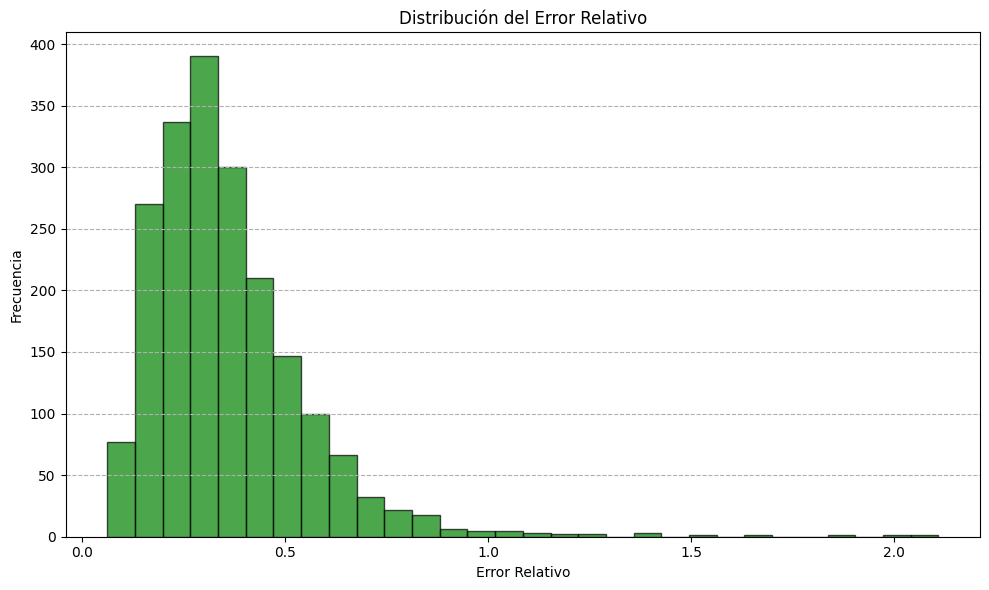

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Establece el tamaño del gráfico
plt.hist(relative_error_per_data, bins=30, edgecolor='black', alpha=0.7, color = 'green')  # Añade bordes negros a las barras y ajusta la transparencia
plt.title('Distribución del Error Relativo')  # Añade un título al gráfico
plt.xlabel('Error Relativo')  # Etiqueta el eje x
plt.ylabel('Frecuencia')      # Etiqueta el eje y
plt.grid(axis='y', linestyle='--')  # Añade una cuadrícula horizontal
plt.tight_layout()  # Ajusta el diseño para evitar que se recorten las etiquetas
plt.show()

# Guardamos los datos de Accuracy y Loss

In [38]:
df = pd.DataFrame.from_dict(history.history)
df.to_csv('../../../Gráficas finales con ruido/History 50,100/historyconvtrayec100.csv', index=False)

# Guardamos el modelo

In [39]:
path_to_save = '../../../Modelos con ruido/Modelos 50,100/'

In [40]:
model.save(path_to_save + '/convolucionaltr100.h5')

# Importamos el modelo

In [1]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [2]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [3]:
import keras
import tensorflow as tf
# Creación de un diccionario con todas las métricas personalizadas
custom_objects = {'custom_activation':custom_activation,'mean_metric': mean_metric}
for i in range(7):
    custom_objects[coeficientesnombres[i]] = mse_component(i)
new_model = keras.models.load_model('../../../Modelos con ruido/Modelos 50,100/convolucionaltr100.h5', custom_objects=custom_objects)

# Probamos el modelo con datos nuevos

## Creamos nuevos datos

In [55]:
import random
from scipy.integrate import solve_ivp
condini = []
varf = []
coef = []
contador = 0
T = 5
t_span = [0,5]
dt = 0.05
N = int(T/dt)

for i in range(0, 1):
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    # Declaramos el vector de tiempo
    t_span = [0, 5]
    times = np.linspace(t_span[0], t_span[1], 100)
    
    varfci2 = []
    for i_ci in range(10):
        # Definimos las condiciones iniciales
        X = np.zeros(N)
        Y = np.zeros(N)
        X[0] = random.randint(0, 10)
        Y[0] = random.randint(0, 10)
        y0 = np.array([X[0], Y[0]])
        condini.append(y0)

        # Simulación con ruido
        for i in range(N-1):
            noise1 = np.random.normal(0, .5)
            noise2 = np.random.normal(0, .5)

            X[i+1] = X[i] + (a1/(1+Y[i]**n) - d1*X[i] + b1)*dt + noise1*np.sqrt(dt)
            Y[i+1] = Y[i] + (a2/(1+X[i]**n) - d2*Y[i] + b2)*dt + noise2*np.sqrt(dt)


        varfci = np.append([X], [Y], axis=0)
        varfci2.append(varfci)

       

    varf= varfci2
    print('--------------------------------------------')
    print(coef1)
    print(np.shape(varf))
varf = np.array(varf)
coef = np.array(coef)

--------------------------------------------
[4, 3, 7, 9, 2, 9, 5]
(10, 2, 100)


In [56]:
varfnone = varf[None, :]
varfnone = np.transpose(varfnone, (0,3,1,2))

## Predecimos con los datos nuevos

In [57]:
new_predictions = new_model.predict(varfnone)
new_predictions = np.round(new_predictions)
new_predictions = np.clip(new_predictions, 0, None)
print(new_predictions)

1/1 [==============================] - 0s 12ms/step
[[ 3.  1.  7.  9.  2. 10.  2.]]


## Graficamos con los coeficientes reales

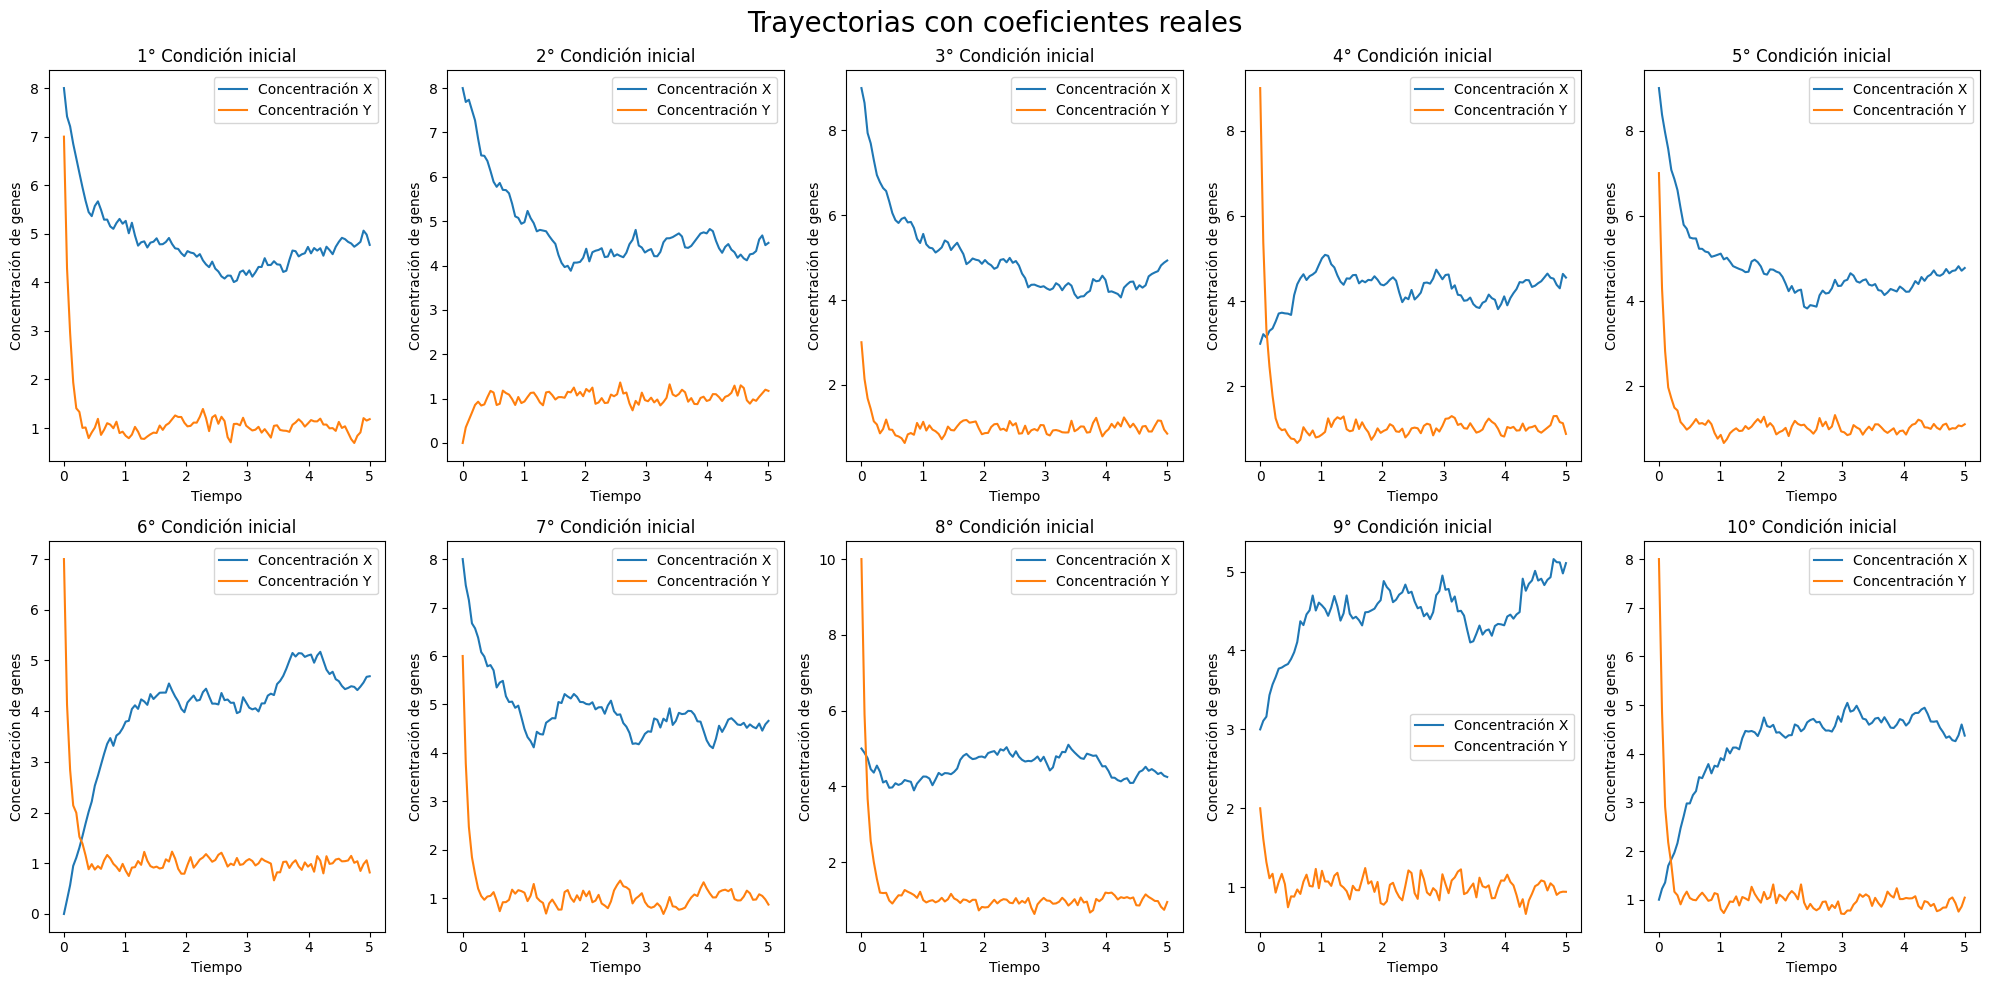

In [58]:
import matplotlib.pyplot as plt
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 100)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 5 filas de gráficos, 2 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    axes[i].plot(times, np.array(varf)[i, 0, :], label=f"Concentración X")
    axes[i].plot(times,np.array(varf)[i,1,:], label=f"Concentración Y")
    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Trayectorias con coeficientes reales', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

In [59]:
np.shape(new_predictions)

(1, 7)

## Graficamos con los coeficientes predecidos

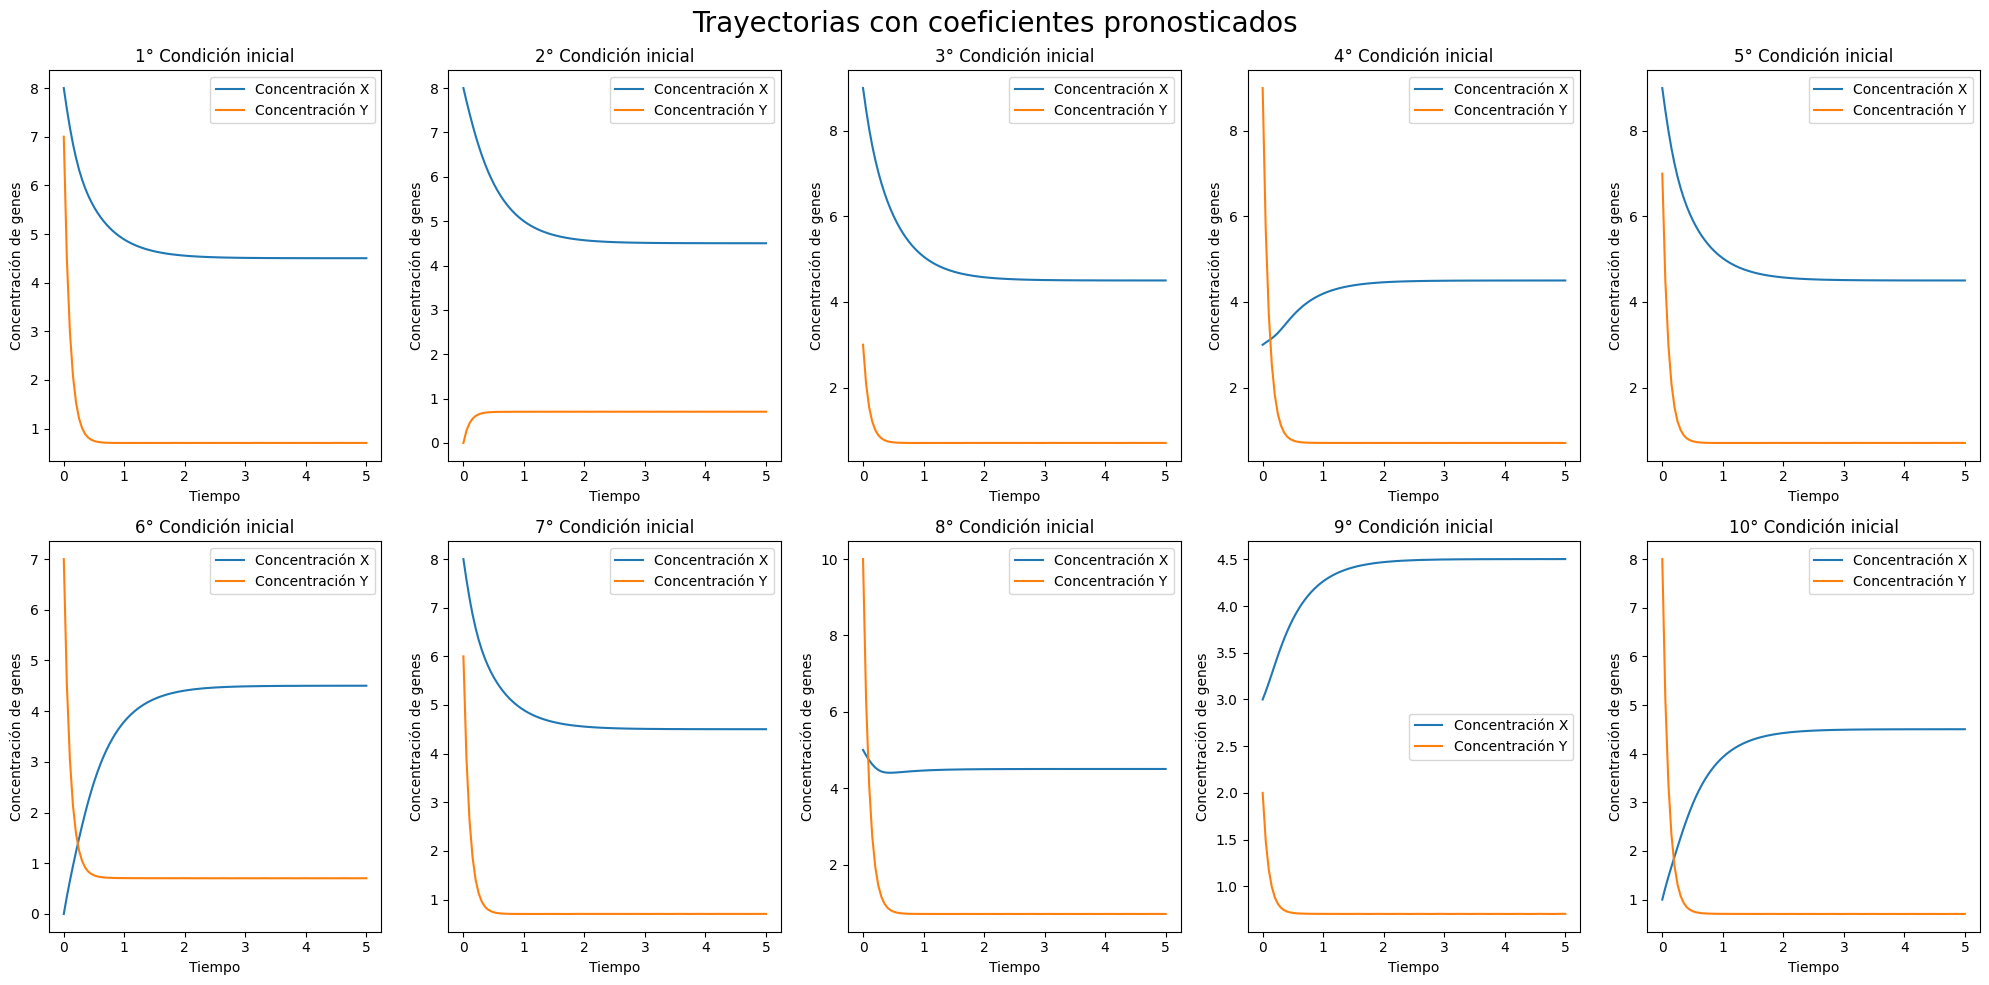

In [60]:
a1 = new_predictions[0,0]
a2 = new_predictions[0,1]
b1 = new_predictions[0,2]
b2 = new_predictions[0,3]
d1 = new_predictions[0,4]
d2 = new_predictions[0,5]
n = new_predictions[0,6]

varfpred = []

def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b1

    return [dX_dt, dY_dt]

# Declaramos el vector de tiempo
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 100)
varfci2pred = []

for i_ci in range(0, 10):
# Definimos las condiciones iniciales
    y0 = condini[i_ci]
    # Resolvemos
    sol = solve_ivp(f, t_span, y0, t_eval=times)
    tiempo = sol.t
    var1pred = sol.y[0]
    var2pred = sol.y[1]
    varfcipred = np.append([var1pred], [var2pred], axis=0)
    varfci2pred.append(varfcipred)
    
varfpred= varfci2pred

fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 5 filas de gráficos, 2 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos
# Graficamos
for i in range(10):
    axes[i].plot(times, np.array(varfpred)[i, 0, :], label=f"Concentración X")
    axes[i].plot(times,np.array(varfpred)[i,1,:], label=f"Concentración Y")
    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Trayectorias con coeficientes pronosticados', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  
plt.show()

## Graficamos ambos

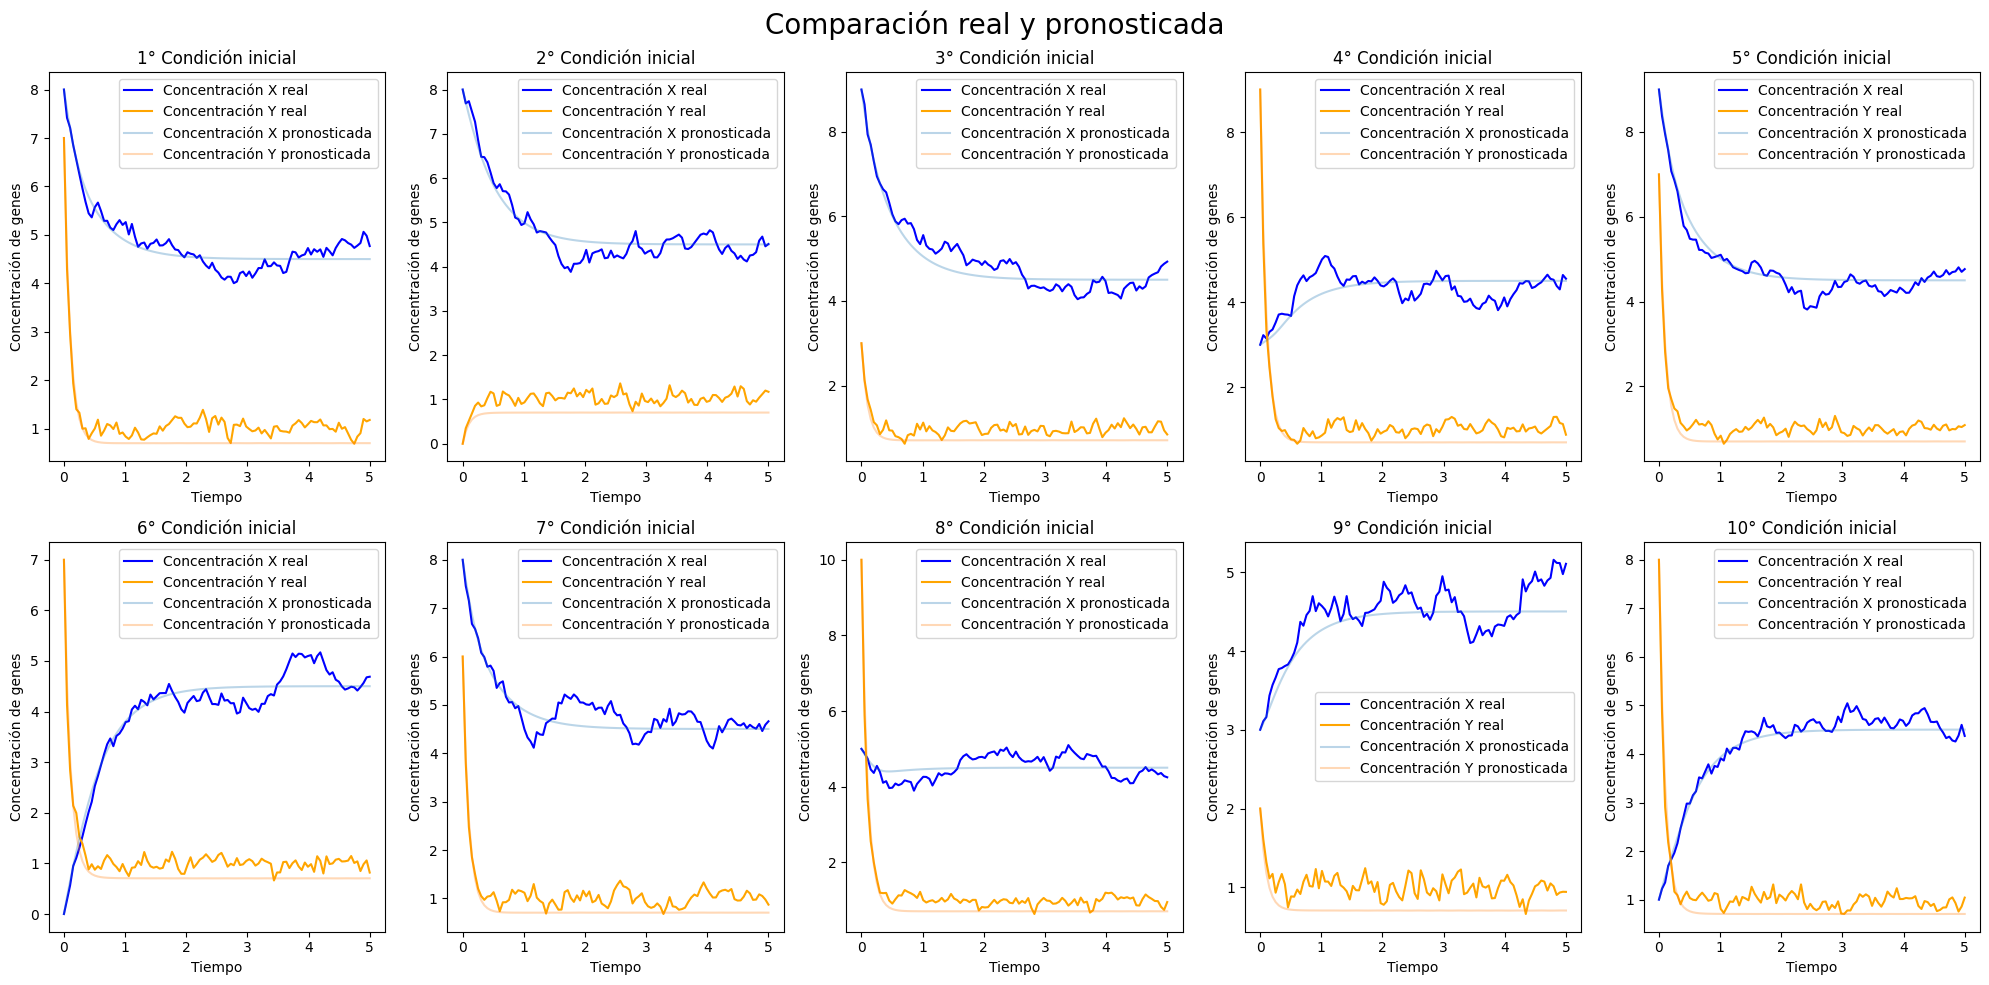

In [61]:
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 100)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    # varf
    axes[i].plot(times, np.array(varf)[i, 0, :], label=f"Concentración X real", alpha=1, color = 'blue')
    axes[i].plot(times,np.array(varf)[i,1,:], label=f"Concentración Y real", alpha=1, color = 'orange')

    # varfpred
    axes[i].plot(times, np.array(varfpred)[i, 0, :], label=f"Concentración X pronosticada", alpha=0.3)
    axes[i].plot(times,np.array(varfpred)[i,1,:], label=f"Concentración Y pronosticada", alpha=0.3)

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación real y pronosticada', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

## Graficamos las diferencias

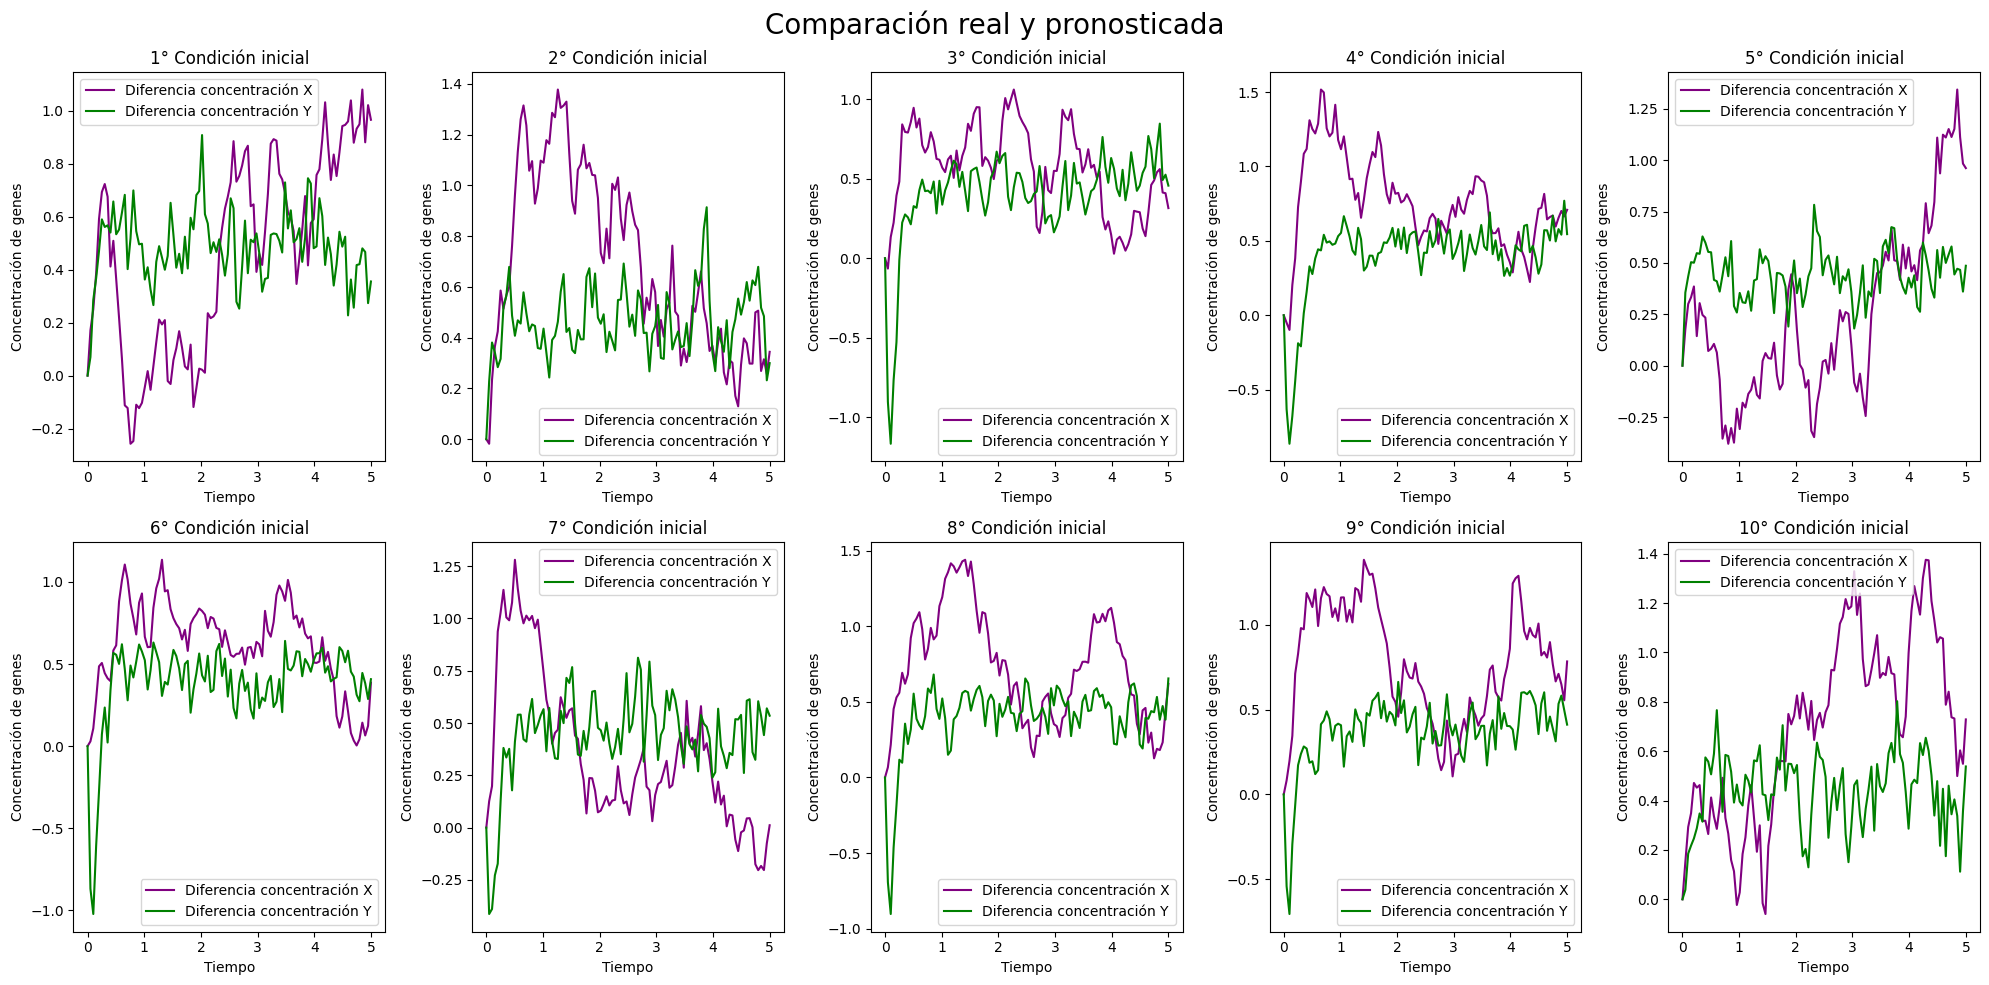

In [78]:
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 100)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

sum_errors_X = []
sum_errors_Y = []
for i in range(10):
    # Diferencia
    diff_X = np.array(varf)[i, 0, :] - np.array(varfpred)[i, 0, :]
    diff_Y = np.array(varf)[i, 1, :] - np.array(varfpred)[i, 1, :]
    axes[i].plot(times, diff_X, label=f"Diferencia concentración X", alpha=1, color = "purple")
    axes[i].plot(times, diff_Y, label=f"Diferencia concentración Y", alpha=1, color = "g")
    # Suma de los errores
    sum_errors_X.append(np.sum(np.abs(diff_X)))
    sum_errors_Y.append(np.sum(np.abs(diff_Y)))

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación real y pronosticada', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

In [79]:
print(np.sum(sum_errors_X)/2000)
print(np.sum(sum_errors_Y)/2000)

0.3028690701268248
0.2245008745129301
